In [1]:
import json
import pandas as pd

### Analysing Keyboard Layout

In [2]:
import cv2
import numpy as np

if False:
    img = cv2.imread("keyboard_layout.jpg")
    points = []

    def click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print((x, y))
            cv2.circle(img, (x, y), 3, (0, 0, 255), -1) # type: ignore
            cv2.imshow("image", img) # type: ignore

    cv2.imshow("image", img) # type: ignore
    cv2.setMouseCallback("image", click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    points_np = np.array(points)
    np.save("data/keyboard_points.npy", points_np)

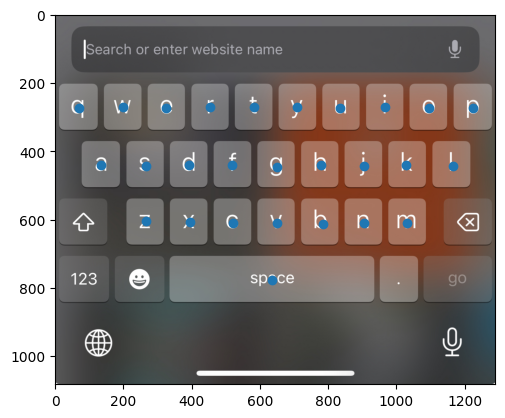

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

qwerty_keys = ["q", "w", "e", "r", "t", "y", "u", "i", "o", "p", "a", "s", "d", "f", "g", "h", "j", "k", "l", "z", "x", "c", "v", "b", "n", "m", " "]
points_np = np.load("data/keyboard_points.npy")
img = mpimg.imread("keyboard_layout.jpg")
coords = []

fig = plt.figure()
plt.imshow(img)
plt.scatter(points_np[:, 0], points_np[:, 1])
plt.show()

In [4]:
key_lookups = {}
for i, key in enumerate(qwerty_keys):
    key_lookups[key] = points_np[i]

### Analysing Keystrokes

In [5]:

with open("data/0.json", "r") as f:
    data = pd.json_normalize(json.load(f))

data = data[data["value"].isin(key_lookups.keys())]

data["dt"] = data["time"].diff()
data["key_pos_x"] = data.apply(lambda x: key_lookups[x["value"]][0], axis=1)
data["key_pos_y"] = data.apply(lambda x: key_lookups[x["value"]][1], axis=1)
data["orientation.normalised_alpha"] = data["orientation.alpha"] - (data["orientation.alpha"] > 150) * 360 

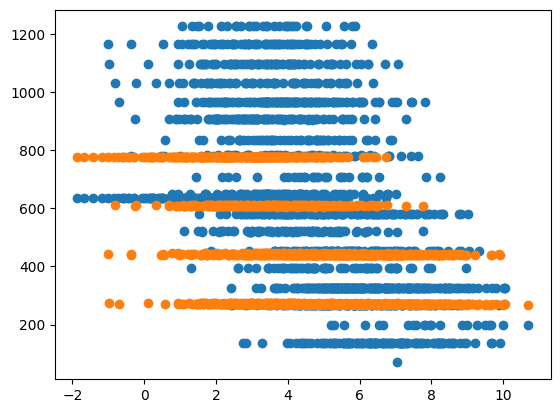

In [6]:
plt.scatter(data["orientation.normalised_alpha"], data["key_pos_x"].to_numpy())
plt.scatter(data["orientation.normalised_alpha"], data["key_pos_y"].to_numpy())

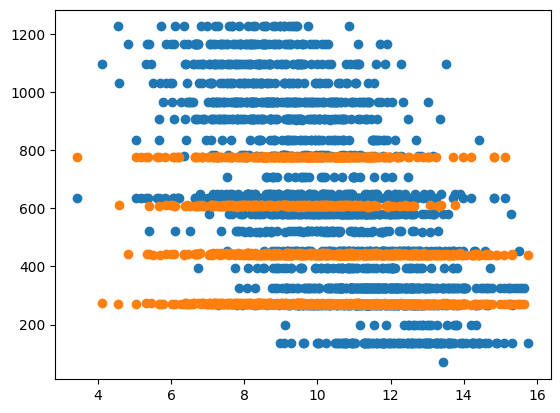

In [7]:
plt.scatter(data["orientation.beta"], data["key_pos_x"].to_numpy())
plt.scatter(data["orientation.beta"], data["key_pos_y"].to_numpy())

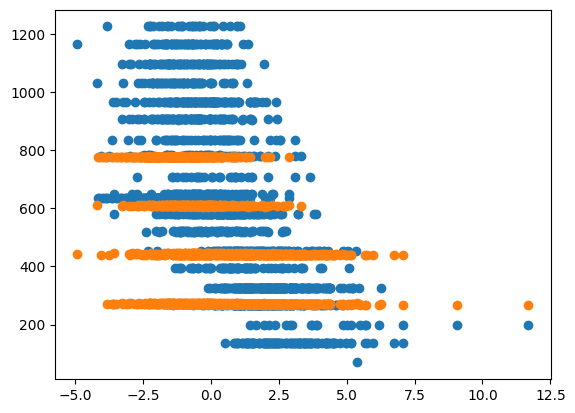

In [8]:
plt.scatter(data["orientation.gamma"], data["key_pos_x"].to_numpy())
plt.scatter(data["orientation.gamma"], data["key_pos_y"].to_numpy())

In [9]:
data["key_angle"] = np.arctan2(data["key_pos_y"] - key_lookups["g"][1], data["key_pos_x"] - key_lookups["g"][0])

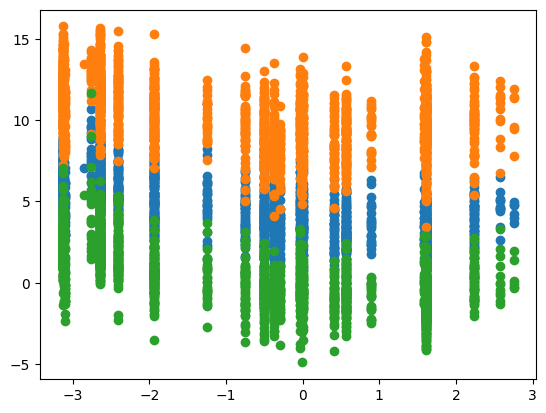

In [10]:
plt.scatter(data["key_angle"].to_numpy(), data["orientation.normalised_alpha"])
plt.scatter(data["key_angle"].to_numpy(), data["orientation.beta"])
plt.scatter(data["key_angle"].to_numpy(), data["orientation.gamma"])

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([12.94080126, 13.04080126, 13.14080126, 13.24080126, 13.34080126,
        13.44080126, 13.54080126, 13.64080126, 13.74080126, 13.84080126,
        13.94080126]),
 <BarContainer object of 10 artists>)

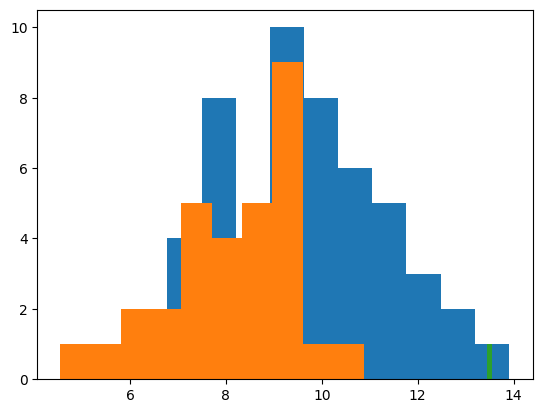

In [11]:
selected = data[data["value"] == "g"]
plt.hist(selected["orientation.beta"])

selected = data[data["value"] == "p"]
plt.hist(selected["orientation.beta"])

selected = data[data["value"] == "q"]
plt.hist(selected["orientation.beta"])

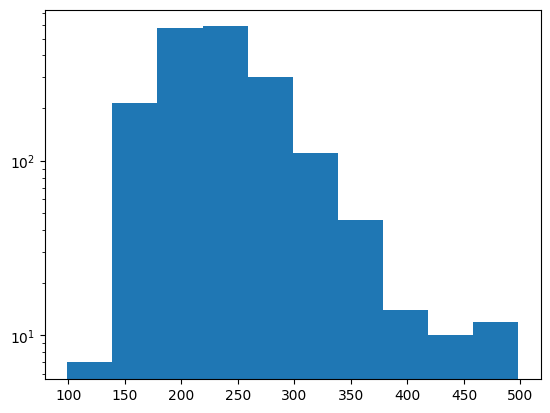

In [12]:
selected = data[data["dt"] < 500]

plt.hist(selected["dt"])
plt.yscale("log")

In [13]:
data["ds"] = np.sqrt(np.array(data["key_pos_x"].diff())**2 + np.array(data["key_pos_y"].diff())**2)

In [14]:
data

,value,time,orientation.alpha,orientation.beta,orientation.gamma,dt,key_pos_x,key_pos_y,orientation.normalised_alpha,key_angle,ds
0,o,1763284461356,4.008805,10.790218,-0.990624,NaN,1096,274,4.008805,-0.368075,NaN
1,c,1763284461664,4.201181,12.581114,1.021694,308.0,521,609,4.201181,2.240278,665.469759
2,e,1763284461919,7.612973,15.303894,2.472462,255.0,326,272,7.612973,-2.648756,389.350742
3,a,1763284462098,7.562402,15.765728,2.366194,179.0,136,441,7.562402,-3.131865,254.285273
4,n,1763284462371,3.812180,13.350897,-1.816711,273.0,906,609,3.812180,0.566982,788.114205
...,...,...,...,...,...,...,...,...,...,...,...
1917,,1763284938953,3.783686,9.842553,-1.924442,319.0,637,778,3.783686,1.609933,513.076992
1918,t,1763284939219,6.476334,10.586372,1.432969,266.0,582,271,6.476334,-1.941412,509.974509
1919,r,1763284939380,5.837865,9.710023,0.719911,161.0,454,270,5.837865,-2.409906,128.003906
1920,i,1763284939616,4.478150,8.150778,-0.888953,236.0,966,270,4.478150,-0.508173,512.000000


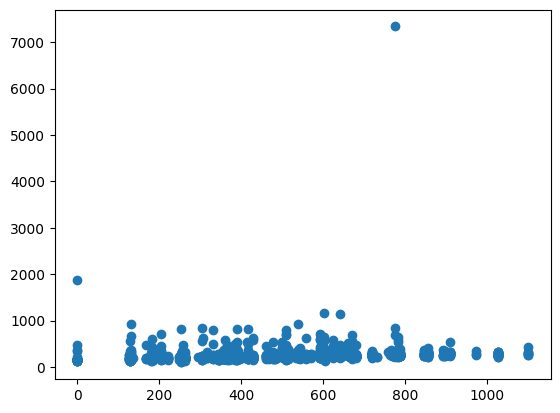

In [15]:
plt.scatter(data["ds"], data["dt"])

(0.027995274275340543, 34291.493869420905)

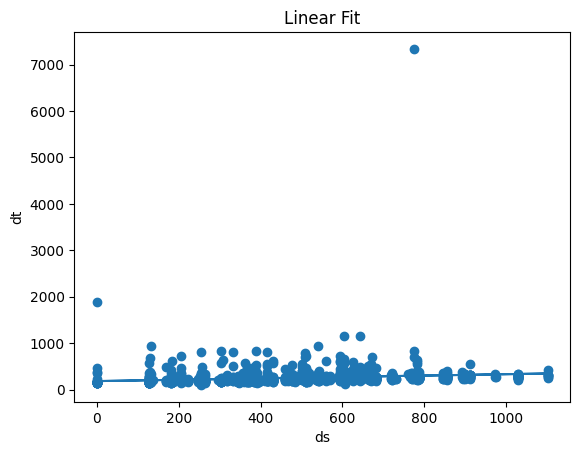

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assume `data` already exists in the environment with columns "ds" and "dt"
X = np.array(data["ds"])[1:].reshape(-1, 1)
y = np.array(data["dt"])[1:]

model = LinearRegression()
model.fit(X, y)

pred = model.predict(X)

r2 = r2_score(y, pred)
mse = mean_squared_error(y, pred)

plt.scatter(data["ds"][1:], data["dt"][1:])
plt.plot(data["ds"][1:], pred)
plt.xlabel("ds")
plt.ylabel("dt")
plt.title("Linear Fit")

(r2, mse)


In [17]:
np.array(data["dt"])[1:].shape

(1917,)

In [18]:
np.array(data["ds"])[1:].reshape(-1, 1).shape

(1917, 1)

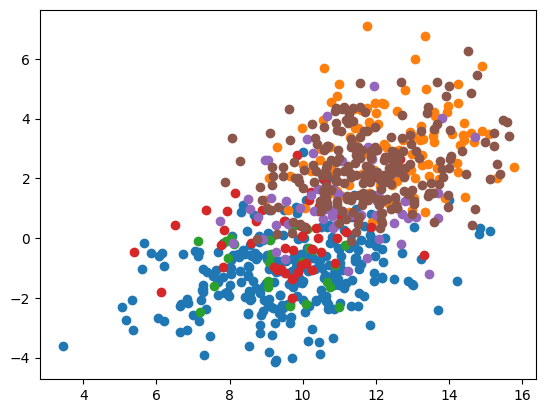

In [19]:

i = 0
for group, rows in data.groupby(data["value"]):
    plt.scatter(rows["orientation.beta"], rows["orientation.gamma"], label=group)

    if i == 5:
        break
    i += 1

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

accuracy: 0.21180555555555555


/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.2847222222222222


In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = HistGradientBoostingClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.21354166666666666


In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = SVC(probability=True)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.2881944444444444


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = KNeighborsClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

accuracy: 0.22395833333333334


/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = MLPClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.2777777777777778


/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["key_pos_x", "key_pos_y"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)   # Y has shape (n_samples, 2)
pred = model.predict(X_test)
print(r2_score(y_test, pred, multioutput='raw_values'))

[0.50036564 0.25964341]


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["key_pos_x", "key_pos_y"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit_transform(X_train)

model = MLPRegressor(hidden_layer_sizes=(32, 32), max_iter=3000)
model.fit(sc.transform(X_train), y_train)

pred = model.predict(sc.transform(X_test))
print(r2_score(y_test, pred, multioutput='raw_values'))

[0.58549631 0.27776523]


In [28]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["key_pos_x", "key_pos_y"]]
y2 = data["value"]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)
y2_train, y2_test = train_test_split(y2, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit_transform(X_train)

model = MultiOutputRegressor(SVR(kernel='rbf', C=10, gamma='scale'))
model.fit(sc.transform(X_train), y_train)

pred = model.predict(sc.transform(X_test))
print(r2_score(y_test, pred, multioutput='raw_values'))


# Try to classify based on minimum distance
def softmax(x):
    x = -x                       # invert so small distance → big score
    x = x - x.max(axis=0, keepdims=True)   # stability
    e = np.exp(x)
    return e / e.sum(axis=0, keepdims=True)


D = np.linalg.norm(pred[:, None, :] - points_np[None, :, :], axis=2)
classifications = np.array(qwerty_keys)[np.argmax(softmax(D), axis=1)]
accuracy_score(classifications, y2_test)

[0.54836008 0.20684823]


0.1076388888888889

In [29]:
data["value_id"] = data.apply(lambda x: qwerty_keys.index(x["value"]), axis=1)

(array([252., 263., 190., 232., 198., 142.,  93.,  18., 100., 430.]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]),
 <BarContainer object of 10 artists>)

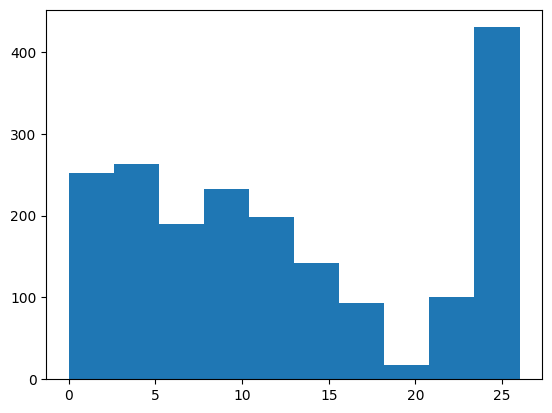

In [30]:
plt.hist(data["value_id"])

In [31]:
data["value"].describe()

count     1918
unique      27
top           
freq       275
Name: value, dtype: object

### Hidden Markov Model

In [118]:
# Train a Markov Chain for the transition probabilities.

from pathlib import Path
import re

regex1 = re.compile(r'[^a-z\s]')
regex2 = re.compile(r'\s+')

sentences = []
data_path = Path("data/text_corpus")
for i, file in enumerate(data_path.iterdir()):
    if i  == 10:
        break
    with open(file, "r") as f:
        for sentence in f.readlines():
            sentences.append(re.sub(regex2, re.sub(regex1, '', sentence.lower().strip()), " "))

    print(f"length: {len(sentences)}, finished file {i}")

length: 306084, finished file 0
length: 612172, finished file 1
length: 918496, finished file 2
length: 1224825, finished file 3
length: 1530893, finished file 4
length: 1837255, finished file 5
length: 2142894, finished file 6
length: 2448272, finished file 7
length: 2754327, finished file 8
length: 3061010, finished file 9


In [119]:
print(sentences[:20])

['get some backbone cameron ', 'in particular  activists say flaws in the legal system have sometimes allowed unwarranted cases to be brought against the media  threatening freedom of expression ', 'smith put the final touch on it  hitting another  and giving his  ok  sign with  seconds to go ', 'jacobson should be ashamed of himself for allowing his partisanship to subdue his moral sense ', 'in a sign of the dire conditions afflicting the entire auto industry  not just the big three  toyota and ford today released us sales figures for november that showed drops in the range of  percent compared to november  ', 'the cowboys seized control of the nfc east by sweeping the season series from the giants and snapping their sixgame win streak with a  win sunday ', 'a series of bombings saturday pointed to the fragility of security gains in the past year ', 'mcclatchy s shares fell  cents to   in morning trading tuesday ', 'in   the tories came back into power under margaret thatcher ', 'roy 

In [ ]:
# Use best model (logistic regression) as emission probabilities.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X = data[["orientation.normalised_alpha", "orientation.beta", "orientation.gamma"]]
y = data[["value"]]
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_train, y_test = train_test_split(y, test_size=0.3, random_state=0)

model = LogisticRegression(max_iter=3000)
model.fit(X_train.to_numpy(), y_train)
pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, pred))

/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.2847222222222222


/home/user/typesnipe/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from pomegranate.distributions._distribution import Distribution
from pomegranate.hmm import DenseHMM
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch

# Create the Hidden Markov Model.
class CustomEmission(Distribution):
    def __init__(self, model: LogisticRegression, target_class: str):
        self.model = model

        class_indices = np.where(model.classes_ == target_class)
        if len(class_indices) == 0:
            raise RuntimeError(f"Model does not include provided class '{target_class}'")
        self.target_class = class_indices[0]
        self.d = model.coef_.shape[1]
        self._initialized = True
        self.check_data = False

    def from_summaries(self, *args):
        # Do nothing, this means the distribution isn't trained.
        pass

    def _reset_cache(self):
        pass

    def log_probability(self, x):
        return torch.tensor(self.model.predict_log_proba(x)[:, self.target_class])


hmm = DenseHMM(distributions=[CustomEmission(model, x) for x in qwerty_keys], starts=np.ones((27,)) / 27, ends=np.ones(27,) / 27)

states = np.vectorize(qwerty_keys.index)(y_test.to_numpy())[np.newaxis, :, :]
X_features = X_test.to_numpy()[np.newaxis, :, :]

hmm.predict(X_features)

tensor([[26, 26,  2, 26,  2,  2, 26, 26,  2, 26,  2,  2, 26,  2, 26,  2, 26,  7,
          2,  2,  2, 26, 26, 26, 26, 26, 26, 26,  2,  2,  2,  2, 26, 26, 26,  2,
          7,  2, 26, 26, 26,  2, 26,  2, 26, 26,  2,  2, 26, 26,  2,  7, 26,  2,
         26, 26, 26,  2,  2, 26, 26, 26, 26,  2,  2,  2,  2, 26, 26, 26, 26,  7,
         26,  2,  2, 26, 26, 26, 26, 26, 26,  7, 26, 26,  2,  2,  7, 26,  2,  2,
          2,  7,  2, 26,  2, 26,  2, 26,  2, 26,  2,  2,  2, 26,  2,  2, 26, 26,
          2,  7,  2,  2, 26, 26, 26, 26,  2, 26,  2, 26,  2,  2, 26,  2, 26, 26,
         26, 26,  2,  2, 26, 26, 26,  2, 26,  2,  2,  2,  2, 26, 26, 26, 26, 26,
         26,  2,  2,  2,  2, 26,  2, 26,  2,  2,  2, 26, 26,  2,  2, 26,  2, 26,
          2, 26, 26, 26, 26,  2,  7,  2, 26, 26, 26, 26,  7,  2, 26, 26,  2, 26,
         26, 26, 26, 26, 26, 26, 26, 26,  2,  2, 26, 26, 26, 26,  2, 26,  2, 26,
          2,  2,  7, 26, 26,  2,  2, 26,  2,  2,  2,  2, 26,  2,  2, 26, 26,  2,
         26,  2,  2, 26,  2,

In [81]:
y_test

,value
361,i
1554,
1250,a
1803,y
427,d
...,...
966,
513,i
71,u
1921,p
